# Natural Language Processing with Deep Learning

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [6]:
#!g1.1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
#!g1.1
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  119M  100  119M    0     0  14.1M      0  0:00:08  0:00:08 --:--:-- 19.2M
Train_rev1.csv


In [3]:
#!g1.1
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
35159,68234257,Chef de Partie up to ****k Cheshire,Chef de Partie – up to ****k – **** star hotel...,Chester Cheshire North West,Chester,NaN,NaN,HTE Recruitment,Hospitality & Catering Jobs,"Up to 17,000 per annum plus tips and cheap liv...",17000,caterer.com,9.741028
123010,69955553,Administrator/Doc Controller,Administrator/Doc Controller Admin Possible te...,Oxford,Oxford,full_time,NaN,NaN,Admin Jobs,"15,000.00 - 20,000.00 per year",17500,Jobcentre Plus,9.770013
169144,71337145,Qualified Social Worker Adoption,My client is currently recruiting a Adoption S...,"South West London, Greater London, South London",London,NaN,NaN,Synergy,Social work Jobs,23.00 - 26.00 per hour,47040,jobs.communitycare.co.uk,10.758775


## Classic NLP approach (70%)

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [7]:
#!g1.1
print("Before")
print(data["Title"][::100000])

Before
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


In [8]:
#!g1.1
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [9]:
#!g1.1
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


In [10]:
#!g1.1
data["Title"][:100]

0                           engineering systems analyst
1                               stress engineer glasgow
2                      modelling and simulation analyst
3     engineering systems analyst / mathematical mod...
4           pioneer , miser engineering systems analyst
                            ...                        
95    chef de parties required nationwide many with ...
96       chef de partie norfolk live in up to **** tips
97                      plastic extrusion setter nights
98    assistant manager suffolk coastal restaurant ****
99                              cluster revenue manager
Name: Title, Length: 100, dtype: object

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
#!g1.1
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
    data[col].apply(lambda x:  token_counts.update(x.split()))

In [12]:
#!g1.1
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

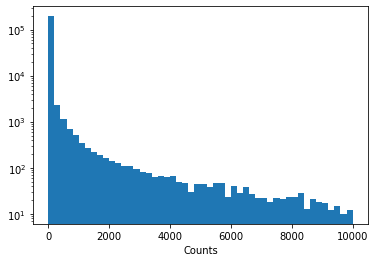

In [13]:
#!g1.1
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [21]:
#!g1.1
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= 10]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [22]:
#!g1.1
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [27]:
#!g1.1
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [28]:
#!g1.1
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [29]:
#!g1.1
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [30]:
#!g1.1
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [31]:
#!g1.1
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [32]:
#!g1.1
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [33]:
#!g1.1
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [87]:
#!g1.1
generate_batch(data_train, 3, max_len=10)

{'Title': array([[1911, 1937,  418,  176],
        [1569,   94,    0,  989],
        [ 998,  101, 1386,    1]], dtype=int32),
 'FullDescription': array([[ 3199,   558,   944,    73, 11885,    86, 10767,   561,  1491,
          1394],
        [ 1569,    94,   160,  2096,    74,    74,  1827,  2977,  3162,
          3057],
        [   55,   110,  1433,   971,  1824,  2497,   998,   101,  1386,
          2133]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.431963,  9.711176, 10.532123], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [88]:
#!g1.1
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [95]:
#!g1.1
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=256, padding_idx=PAD_IX)
        self.conv = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.global_max = GlobalMaxPooling()
        self.dense = nn.Linear(128, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        # Apply the layers as defined above. Add some ReLUs before dense.
        #YOU CODE HERE
        h = nn.ReLU()(self.global_max(self.conv(h)))
        h = self.dense(h)
        return h

In [96]:
#!g1.1
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [98]:
#!g1.1
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=256, padding_idx=PAD_IX)
        self.conv = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.global_max = GlobalMaxPooling()
        self.dense = nn.Linear(128, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        #YOU CODE HERE
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h = nn.ReLU()(self.global_max(self.conv(h)))
        h = self.dense(h)
        return h

In [99]:
#!g1.1
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [122]:
#!g1.1
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size = 64)
        
        self.categ_dense1 = nn.Linear(n_cat_features, 512)
        self.categ_dense2 = nn.Linear(512, 128)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense1 = nn.Linear(256, 128)
        self.dense2 = nn.Linear(128, 100)
        self.dense3 = nn.Linear(100, 64)
        
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        #YOU CODE HERE
        cat_h = nn.ReLU()(self.categ_dense1(cat_features))
        cat_h = nn.ReLU()(self.categ_dense2(cat_h))        
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        #YOU CODE HERE
        joint_h = nn.ReLU()(self.dense1(joint_h))
        joint_h = nn.ReLU()(self.dense2(joint_h))
        joint_h = nn.ReLU()(self.dense3(joint_h))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:, 0]

In [123]:
#!g1.1
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [124]:
#!g1.1
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [125]:
#!g1.1
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [126]:
#!g1.1
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [127]:
#!g1.1
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [128]:
#!g1.1
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
#!g1.1
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)
#         print(prediction[:3])
#         print(reference[:3])
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import os


Training:

	Loss:	21.59133
	MAE:	67436.76451



Validation:

	Loss:	0.59571
	MAE:	5941.75549



Training:

	Loss:	0.42370
	MAE:	5836.97553



Validation:

	Loss:	0.34870
	MAE:	5656.94859



Training:

	Loss:	0.29217
	MAE:	4907.73334



Validation:

	Loss:	0.29068
	MAE:	5220.50341



Training:

	Loss:	0.27963
	MAE:	4738.64593



Validation:

	Loss:	0.28924
	MAE:	4375.95423



Training:

	Loss:	0.25048
	MAE:	4636.85185



Validation:

	Loss:	0.21915
	MAE:	4464.05179



Training:

	Loss:	0.23194
	MAE:	4418.30160



Validation:

	Loss:	0.20206
	MAE:	4270.59404



Training:

	Loss:	0.19524
	MAE:	3941.87349



Validation:

	Loss:	0.18311
	MAE:	3816.83471



Training:

	Loss:	0.19322
	MAE:	4035.42668



Validation:

	Loss:	0.17144
	MAE:	3682.30059



Training:

	Loss:	0.19457
	MAE:	4049.53688



Validation:

	Loss:	0.21650
	MAE:	5027.98472



Training:

	Loss:	0.17658
	MAE:	3904.31595



Validation:

	Loss:	0.22910
	MAE:	4134.92998



Training:

	Loss:	0.17229
	MAE:	3939.02496



Validation:



	Loss:	0.09911
	MAE:	2900.75312



Training:



	Loss:	0.10367
	MAE:	3107.93588



Validation:



	Loss:	0.12080
	MAE:	3175.49011



Training:



	Loss:	0.11639
	MAE:	3284.26886



Validation:



	Loss:	0.09791
	MAE:	2974.31432



Training:



	Loss:	0.10527
	MAE:	3139.15747



Validation:



	Loss:	0.11597
	MAE:	3136.21436



Training:



	Loss:	0.10538
	MAE:	3104.19102



Validation:



	Loss:	0.09718
	MAE:	3024.74099



Training:



	Loss:	0.11118
	MAE:	3238.60521



Validation:


In [ ]:
#!g1.1
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()
    val_mae += compute_mae(reference, prediction).data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

### Task 3: explaining network predictions (optional)

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [ ]:
#!g1.1
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """

    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 
    batch = generate_batch(data_drop_one_token)
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)

    *predictions_drop_one_token, baseline_pred = model.cpu()(title_ix, desc_ix, cat_features).data.numpy()
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))
    
    # compute model prediction on sample (scalar float log-salary)
    # baseline_pred = <YOUR CODE>
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    # predictions_without_word = <YOUR CODE>
    
    # score_differences = [
       # prediction - baseline_pred for prediction in predictions_without_word
    #]
    
    # return a list of pairs: [(token, score_difference)]

    #return <YOUR CODE>

In [ ]:
#!g1.1
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

In [ ]:
#!g1.1
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [ ]:
#!g1.1
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
print("Salary (gbp):", <YOUR CODE>)

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

### Task 4: Actually make it work: try more architectures

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

# Regression with BERT (Pre-training of Deep Bidirectional Transformers for Language Understanding)

<img src="https://chernobrovov.ru/assets/images/bert0.png" width=500px>

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.
BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

You can find more information in in https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270 or directly from paper: https://arxiv.org/abs/1810.04805

In [ ]:
!pip install transformers

To do:

* Create a proper dataset
* Select and load proper tokenizer from https://huggingface.co/transformers/fast_tokenizers.html

Dealing with Hugginface is possible in 2 ways: Hard and Effective.

<img src="https://i.pinimg.com/564x/21/29/6a/21296a88cdae259e0507a2e63174b1e7.jpg" width=300px>

> ### Take Ring to Mordor by Fellowship campaine (Hard):
* Select a model class from https://huggingface.co/transformers/task_summary.html
* Create Bert object from one of the available pre-trained configurations.
* Add several layers (head) in the top of model's output to transform output to regression logits.
* Note, in the general case, for smoothly training a Bert with a head, either a very good schedule or different learning rates for parameters in Bert part and for head.



> ### Take Ring to Mordor by Eagles (Effective):
* Select a model class from https://huggingface.co/transformers/task_summary.html with parameters that allow to train linear regression
* Create Bert object from one of the available pre-trained configurations
* Train it by hand-written training loop or Trainer (https://huggingface.co/transformers/main_classes/trainer.html#transformers Trainer)

**Note**: any transformer-based model is weighty and tremendous, and there may not be enough memory in your laptop or collab to work with it.

We do not recommend loading and using models with the prefix 'large'. If, nevertheless, we obtain a **lack of memory**, you can:
* reduce the salary dataset to $50*10^3$
* reduce batch size
* reduce number of objects involved in the train (for example, abandon Train() in favor of regular training loop)



In [ ]:
#!g1.1
model_checkpoint = "bert-base-uncased"
batch_size = 16

In [ ]:
#!g1.1
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
#!g1.1
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

## Dataset: 

In [ ]:
#!g1.1
def read_text_labels_from_df(salary_df):
    texts = []
    labels = []
    for ind, elem in enumerate(salary_df["Title"]):
        try:
          text = elem + salary_df["FullDescription"][ind]
          label = salary_df["Log1pSalary"][ind]
          texts.append(text)
          labels.append([label])
        except:
          print ("smth went wrong")

    return texts, labels


In [ ]:
#!g1.1
from sklearn.model_selection import train_test_split
texts, labels = read_text_labels_from_df(data)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts[:5000], labels[:5000], test_size=.2)

In [ ]:
#!g1.1
train_encodings = #YOU_CODE_HERE
test_encodings = #YOU_CODE_HERE

In [ ]:
#!g1.1
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#YOU_CODE_HERE

In [ ]:
#!g1.1
from transformers import Trainer

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = #YOU_CODE_HERE
model.to(device)
model.train()

training_args = #YOU_CODE_HERE

optim = #YOU_CODE_HERE

#and then only YOU_CODE_HERE. Feel free!

# A short report

Please tell us what you did and how did it work for classical NLP task and for BERT.

`<YOUR_TEXT_HERE>`, i guess...